In [1]:
import torch
print(torch.__version__)
device = torch.device("cuda")
torch.cuda.get_device_name(device)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr

2.0.0.post304


In [4]:
import os
# os.environ.pop("MPLBACKEND", None)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

from upt.datasets.simulation_dataset import SimulationDataset

from upt.models.upt import UPT
from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.conditioner_timestep import ConditionerTimestep

from upt.collators.simulation_collator import SimulationCollator
from torch.utils.data import DataLoader

import imageio
from pathlib import Path
from matplotlib import patches
import numpy as np

In [5]:
train_dataset = SimulationDataset(
    root="./data",
    # how many inputs to use for training
    num_inputs=4096,
    # how many outputs to use for training
    num_outputs=4096,
    # mode
    mode="train",
)

In [6]:
dim = 96
# dim = 192
num_heads = 1
epochs = 10
batch_size = 4

In [7]:
conditioner = ConditionerTimestep(
    dim=dim,
    num_timesteps=train_dataset.num_timesteps,
)
model = UPT(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        # simulation has 3 inputs: 2D velocity + pressure
        input_dim=1,
        # 2D dataset
        ndim=2,
        # positions are rescaled to [0, 200]
        radius=5,
        # in regions where there are a lot of mesh cells, it would result in supernodes having a lot of
        # connections to nodes. but since we sample the supernodes uniform, we also have a lot of supernodes
        # in dense regions, so we can simply limit the maximum amount of connections to each supernodes
        # to avoid an extreme amount of edges
        max_degree=32,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=4,
        # downsample to 128 latent tokens for fast training
        perc_dim=dim,
        perc_num_heads=num_heads,
        num_latent_tokens=128,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 2D velocity + pressure
        output_dim=1,
        # simulation is 2D
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
        # we assume num_outputs to be constant so we can simply reshape the dense result into a sparse tensor
        unbatch_mode="dense_to_sparse_unpadded",
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

parameters: 4.9M


In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=SimulationCollator(num_supernodes=512, deterministic=False),
    num_workers=0,
)
# setup dataset for quickly evaluating the rollout error during training
rollout_dataset = SimulationDataset(
    root="./data",
    # use all inputs for rollout
    num_inputs=4096,
    # use all outputs for rollout
    num_outputs=4096,
    # mode
    mode="rollout",
)
rollout_dataloader = DataLoader(
    dataset=rollout_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=SimulationCollator(num_supernodes=256, deterministic=True),
)

In [12]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05, foreach=False)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

In [10]:
def _rollout_list_to_numpy(rollout_preds):
    """
    Convert rollout_preds (list of length T) to numpy array shape (bsz, T, n_points, n_channels).
    rollout_preds[i] may be torch.Tensor of shape (bsz, n_points, n_channels) or (n_points, n_channels)
    """
    arrs = []
    for p in rollout_preds:
        if isinstance(p, torch.Tensor):
            p_np = p.detach().cpu().numpy()
        else:
            p_np = np.asarray(p)
        # ensure batch dim
        if p_np.ndim == 2:
            p_np = p_np[np.newaxis, ...]   # (1, n_points, channels)
        arrs.append(p_np)  # list of (bsz, n_points, channels)
    # stack -> (bsz, T, n_points, channels)
    stacked = np.stack(arrs, axis=1)
    return stacked

In [14]:
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description(
    f"train_loss: ??????? "
    f"rollout_loss: ???????"
)
train_losses = []
rollout_losses = []
rollout_loss = 0.
loss = None

results_dir = "./results_rollouts"
os.makedirs(results_dir, exist_ok=True)
per_sample_dir = os.path.join(results_dir, "per_sample")
os.makedirs(per_sample_dir, exist_ok=True)

all_preds_batches = []   # will store arrays (bsz, T, n_points, ch)
all_gts_batches = []
all_ids_batches = []     # store sample ids in same order as batches
coords_saved = None      # will be filled from a test_batch (output_pos / input_pos)

for _ in range(epochs):
    # train for an epoch
    model.train()
    for batch in train_dataloader:
        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            timestep=batch["timestep"].to(device),
        )
        y = batch["output_feat"].to(device)
        loss = F.mse_loss(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        update += 1
        pbar.update()
        pbar.set_description(
            f"train_loss: {loss.item():.6f} "
            f"rollout_loss: {rollout_loss:.6f}"
        )
        train_losses.append(loss.item())

    for test_batch in rollout_dataloader:
        with torch.no_grad():
            rollout_preds = model.rollout(
                input_feat=test_batch["input_feat"].to(device),
                input_pos=test_batch["input_pos"].to(device),
                supernode_idxs=test_batch["supernode_idxs"].to(device),
                batch_idx=test_batch["batch_idx"].to(device),
            )
            assert len(test_batch["output_feat"]) == 1, "batch_size for rollout should be 1"
            output_feat = test_batch["output_feat"][0]

            num_rollout_timesteps = len(output_feat)
            rollout_loss = 0.
            for i in range(num_rollout_timesteps):
                pred = rollout_preds[i]
                target = output_feat[i]
                rollout_loss += F.mse_loss(pred, target.to(device))
            rollout_loss /= num_rollout_timesteps
        rollout_losses.append(rollout_loss)
        pbar.set_description(
            f"train_loss: {loss.item():.6f} "
            f"rollout_loss: {rollout_loss:.6f}"
        )

if len(all_preds_batches) > 0:
    preds_all = np.concatenate(all_preds_batches, axis=0)  # (N_test, T, n_points, ch)
    gts_all = np.concatenate(all_gts_batches, axis=0)
    ids_all = np.concatenate(all_ids_batches, axis=0)

    # save compressed single-file summary
    out_npz = os.path.join(results_dir, "preds_all.npz")
    np.savez_compressed(
        out_npz,
        preds=preds_all.astype(np.float32),
        gts=gts_all.astype(np.float32),
        coords=coords_saved.astype(np.float32),
        ids=ids_all.astype(int),
    )
# save results
pbar.close()

train_loss: 0.525015 rollout_loss: 1.130078: 100%|██████████| 57000/57000 [1:52:46<00:00,  8.42it/s]    


In [19]:
ckpt_path = os.path.join(results_dir, "upt_full_checkpoint.pt")
torch.save({
    "epoch": _,  # last completed epoch
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optim.state_dict(),
    # if using lr scheduler:
    # "scheduler_state_dict": scheduler.state_dict(),
    # if using AMP GradScaler:
    # "scaler_state_dict": scaler.state_dict(),
    "train_losses": train_losses,
    "rollout_losses": rollout_losses,
    # metadata
    "git_commit": "<commit-hash-or-empty>",
    "training_config": {"batch_size": batch_size, "lr": 1e-3},  # add what you need
}, ckpt_path)

In [ ]:
# checkpoint = torch.load(ckpt_path, map_location="cuda:0")  # or map_location="cpu"
# model.load_state_dict(checkpoint["model_state_dict"])
# optim.load_state_dict(checkpoint["optimizer_state_dict"])
# epoch = checkpoint.get("epoch", 0)
# if "scaler_state_dict" in checkpoint and scaler is not None:
#     scaler.load_state_dict(checkpoint["scaler_state_dict"])
# model.to(device)
# model.train()  # or model.eval() if only inference

/tmp/ipykernel_132176/1152069813.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

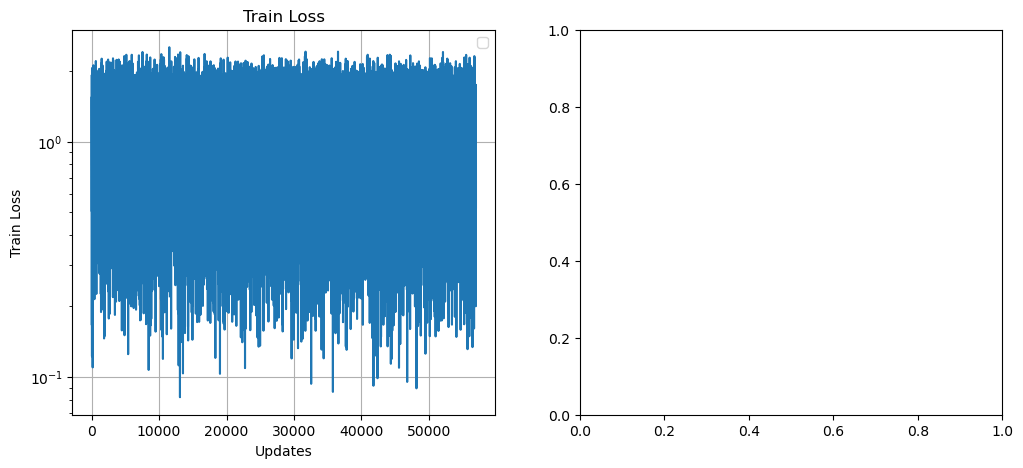

In [15]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True)
axes[1].plot(range(len(rollout_losses)), rollout_losses)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Rollout Loss")
axes[1].set_title("Rollout Loss")
axes[0].set_yscale("log")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rollout_dataloader = DataLoader(
    dataset=rollout_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=SimulationCollator(num_supernodes=2048, deterministic=True),
)
test_batch = next(iter(rollout_dataloader))

In [ ]:
rollout_preds = model.rollout(
    input_feat=test_batch["input_feat"].to(device),
    input_pos=test_batch["input_pos"].to(device),
    supernode_idxs=test_batch["supernode_idxs"].to(device),
    batch_idx=test_batch["batch_idx"].to(device),
)
rollout_preds = [rollout_preds[i].cpu() for i in range(len(rollout_preds))]

In [12]:
out = Path("tmp")
if out.exists():
    import shutil
    shutil.rmtree(out)
out.mkdir()
assert len(test_batch["output_feat"]) == 1, "batch_size > 1 not supported for rollout"
output_feat = test_batch["output_feat"][0]
num_rollout_timesteps = len(output_feat)
x, y = test_batch["input_pos"].unbind(1)
for i in tqdm(range(num_rollout_timesteps)):
    plt.clf()
    fig = plt.figure(figsize=(30, 10))
    # needed to force correct aspect ratio
    positions = [
        [0.05, 0.1, 0.3, 0.8],
        [0.4, 0.1, 0.3, 0.8],
        [0.7, 0.1, 0.3, 0.8],
    ]
    ax = [fig.add_axes(pos) for pos in positions]
    # plot only velocity magnitude
    pred = rollout_preds[i][:, 1:]
    target = output_feat[i][:, 1:]
    delta = (pred - target).norm(dim=1)
    pred = pred.norm(dim=1)
    target = target.norm(dim=1)
    # format
    for ii in range(3):
        rect = patches.Rectangle((0, 0), 200, 300, facecolor="#ee8866", zorder=-10)
        ax[ii].add_patch(rect)
        ax[ii].set_axis_off()
        ax[ii].set_xlim(5, 295)
        ax[ii].set_ylim(5, 195)
        ax[ii].set_aspect(1.0)
    # plot displacement (plot with large pointsize first to fill whole area, then with small one for details)
    for point_size in [20, 4]:
        ax[0].scatter(x, y, c=target, s=point_size, cmap="bone", vmin=0, vmax=2.5)
        scatter1 = ax[1].scatter(x, y, c=pred, s=point_size, cmap="bone", vmin=0, vmax=2.5)
        scatter2 = ax[2].scatter(x, y, c=delta, s=point_size, cmap="bone", vmin=0, vmax=0.4)
    ax[0].set_title("target")
    ax[1].set_title("prediction")
    ax[2].set_title("delta")
    plt.colorbar(scatter1, ax=[ax[0], ax[1]], orientation="vertical")
    plt.colorbar(scatter2, ax=ax[2], orientation="vertical")
    # save
    plt.savefig(out / f"{i:04d}.png")
    plt.close()

100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


<Figure size 640x480 with 0 Axes>

In [13]:
images = [
    imageio.imread(out / f"{i:04d}.png")
    for i in range(num_rollout_timesteps)
]
imageio.mimsave(out / "rollout.gif", images, duration=0.1, loop=0)

/tmp/ipykernel_2924346/2846539399.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(out / f"{i:04d}.png")


In [14]:
Image(open(out / "rollout.gif", "rb").read())

NameError: name 'Image' is not defined

In [ ]:
Image(open(out / "0005.png", "rb").read())